## Recreating the Master Unit List

#### setup/imports

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import numpy as np
import pudl
import pudl.constants as pc
import pudl.extract.ferc1
import sqlalchemy as sa
import logging
import sys
import copy
from copy import deepcopy

In [3]:
import matplotlib.pyplot as plt
import matplotlib as mpl
%matplotlib inline

In [4]:
import sys
sys.path.append("../") # go to parent dir
from plant_part_agg_eia import *
from plant_parts import plant_parts

In [5]:
logger = logging.getLogger()
logger.setLevel(logging.INFO)
handler = logging.StreamHandler(stream=sys.stdout)
formatter = logging.Formatter('%(message)s')
handler.setFormatter(formatter)
logger.handlers = [handler]

#### defining a table grabbing object

In [6]:
pudl_settings = pudl.workspace.setup.get_defaults()
pudl_engine = sa.create_engine(pudl_settings["pudl_db"])
pt = pudl.output.pudltabl.get_table_meta(pudl_engine)
start_date=None
end_date=None
freq='AS'

In [7]:
from plant_parts import plant_parts

In [8]:
self = CompileTables(pudl_engine, freq='AS', rolling=True)

In [9]:
compiled_plant_parts = self.generate_master_unit_list(plant_parts)

   begining the aggregation for generators_eia860
   grabbing generators_eia860 from the sqlite db
   begining the aggregation for generation_eia923
   grabbing generation_eia923 from the sqlite db
   begining the aggregation for mcoe
   grabbing mcoe from the output object
filling in fuel cost NaNs with rolling averages
   grabbing ownership_eia860 from the sqlite db
droping 27 records without capacity
plant
   aggregate the parts
plant_gen
   aggregate the parts
plant_unit
   denormiiee
   grabbing boiler_generator_assn_eia860 from the sqlite db
   aggregate the parts
plant_technology
   denormiiee
   aggregate the parts
plant_prime_fuel
   denormiiee
   aggregate the parts
plant_prime_mover
   denormiiee
   grabbing generators_entity_eia from the sqlite db
   aggregate the parts


In [10]:
# 1) aggregate the data points by generator
plant_gen_df = self.aggregate_plant_part(plant_parts['plant_gen'])
# 2) generating proportional data by ownership %s
plant_gen_df = self.slice_by_ownership(plant_gen_df)

   begining the aggregation for generators_eia860
   begining the aggregation for generation_eia923
   begining the aggregation for mcoe
droping 27 records without capacity


In [11]:
# 3) aggreate everything by each plant part
compiled_dfs = {}
for part_name, plant_part in plant_parts.items():
    logger.info(part_name)
    if plant_part['denorm_table']:
        logger.info('   denormiiee')
        compiled_dfs[part_name] = self.agg_cols(
            plant_part,
            self.denoramlize_table(plant_gen_df,
                                   plant_part['id_cols'],
                                   plant_part['denorm_table'],
                                   plant_part['denorm_cols'],
                                   ))
    else:
        compiled_dfs[part_name] = self.agg_cols(
            plant_part,
            plant_gen_df)

plant
   aggregate the parts
plant_gen
   aggregate the parts
plant_unit
   denormiiee
   aggregate the parts
plant_technology
   denormiiee
   aggregate the parts
plant_prime_fuel
   denormiiee
   aggregate the parts
plant_prime_mover
   denormiiee
   aggregate the parts


In [12]:
def plot_plant_vs_agg(compiled_plant_parts, field, xy_limits, scale):
    """
    Make plots to compare FERC & EIA reported values for Coal & Gas plants.
    
    For each of the fields specified in fields_to_plot, create a pair of plots,
    one for 'gas' and one for 'coal' in the same frame, showing the EIA quantity
    vs. the FERC quantity in a scatter plot.
    """
    for plant_gran, df in compiled_plant_parts.items():
        if plant_gran == 'plant':
            pass
        field_plant = field+'_plant'
        field_gran = field+'_'+plant_gran
        try:
            merge_df = compiled_plant_parts['plant'].merge(df, on=['plant_id_eia', 'report_date'], suffixes=('_plant','_' + plant_gran))
            # this is for the try
            merge_df[field_gran]
            fig, (ax) = plt.subplots(ncols=1, nrows=1, figsize=(8, 8))
            ax.scatter(merge_df[field_plant],
                       merge_df[field_gran],
                       color='black', alpha='0.1', label=field)
            ax.set_ylim(xy_limits[field][0],xy_limits[field][1])
            ax.set_xlim(xy_limits[field][0],xy_limits[field][1])
            ax.set_xscale(scale)
            ax.set_yscale(scale)
            ax.set_ylabel(f'{plant_gran} {field}')
            ax.set_xlabel(f'Plant {field}')
            ax.set_title(f"Plant vs {plant_gran}: {field}")
        except KeyError:
            pass

/Users/christinagosnell/miniconda3/envs/pudl-dev/lib/python3.7/site-packages/ipykernel_launcher.py:18: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


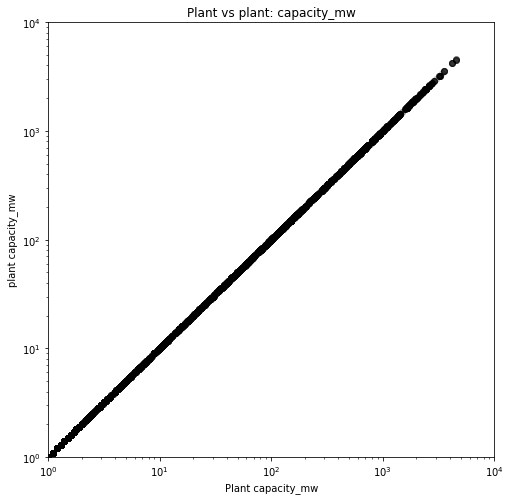

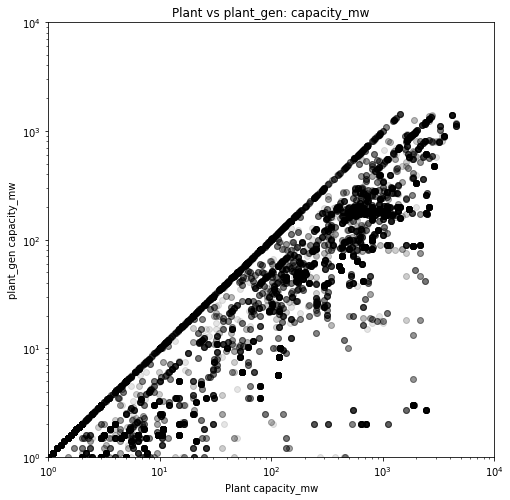

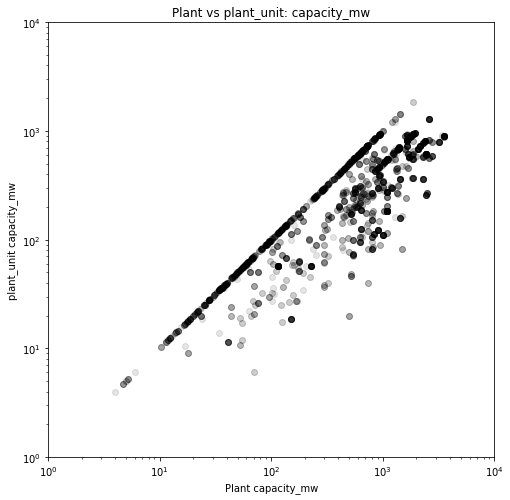

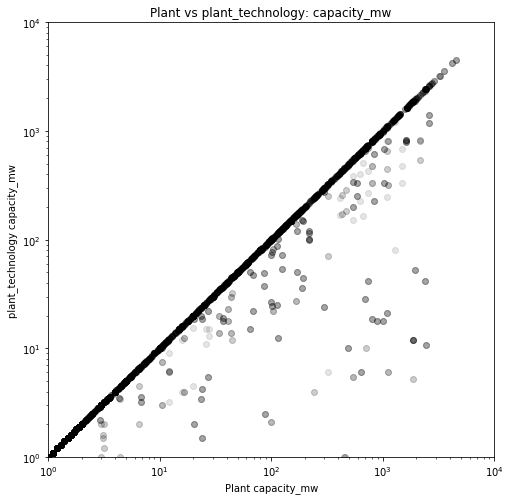

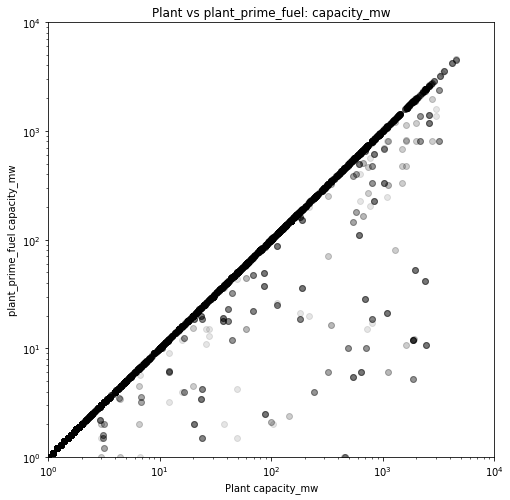

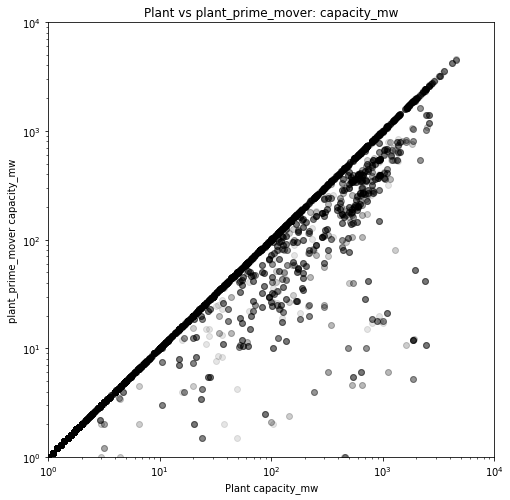

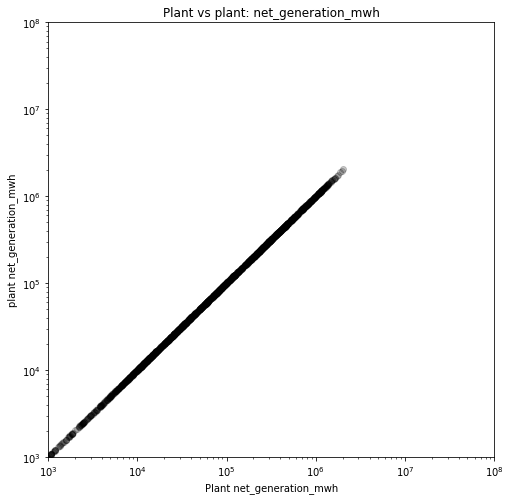

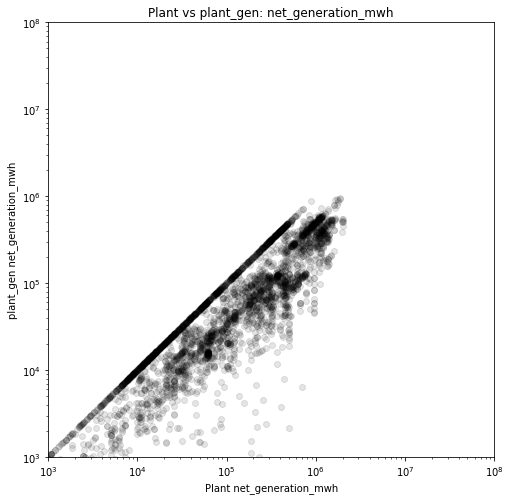

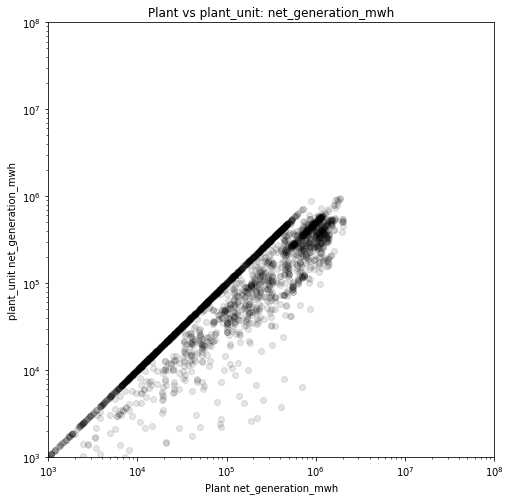

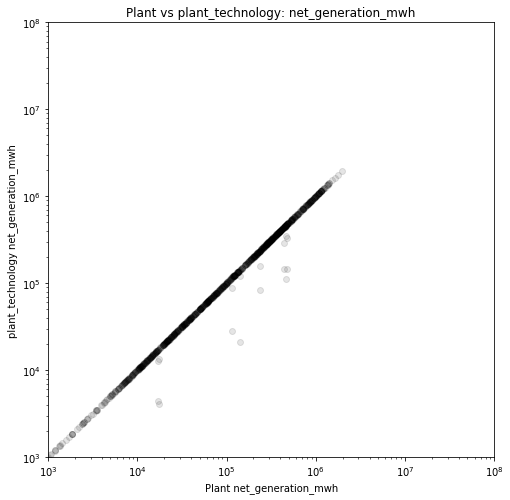

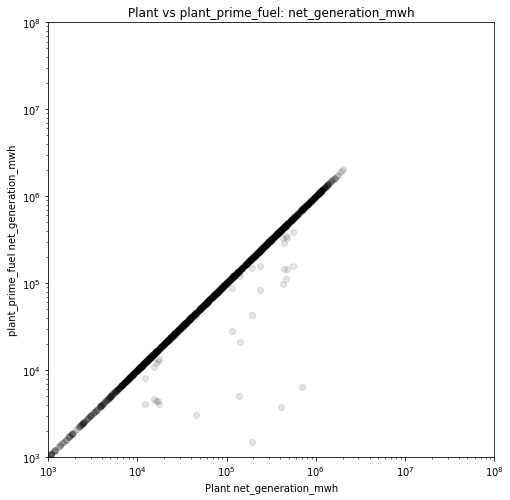

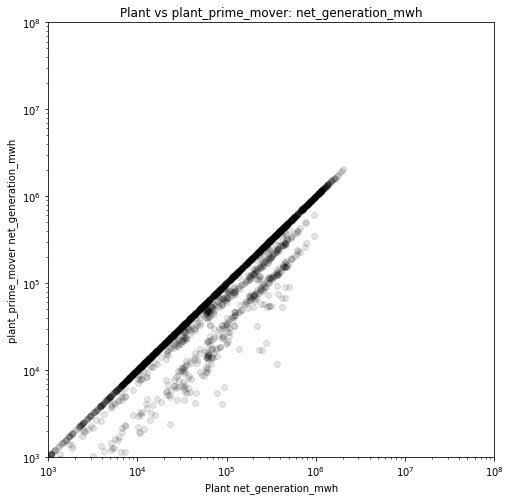

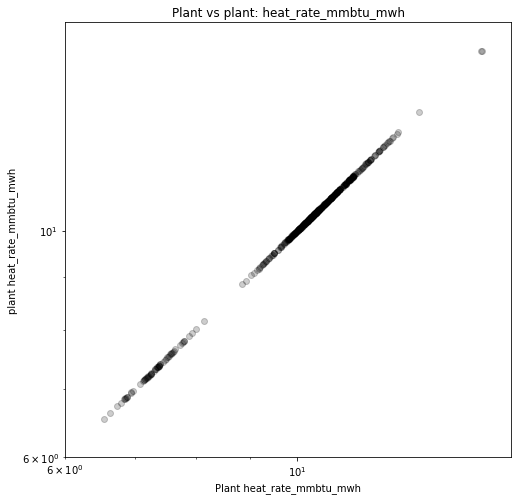

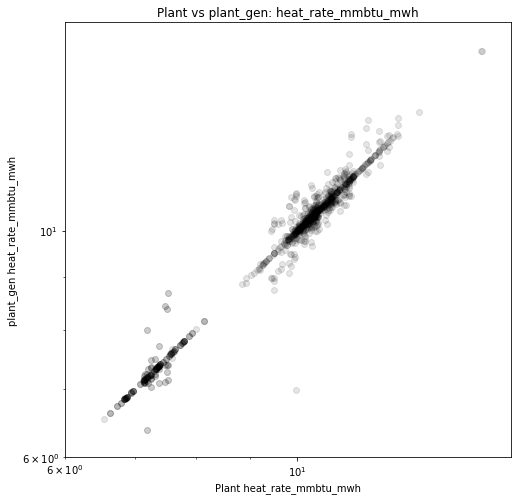

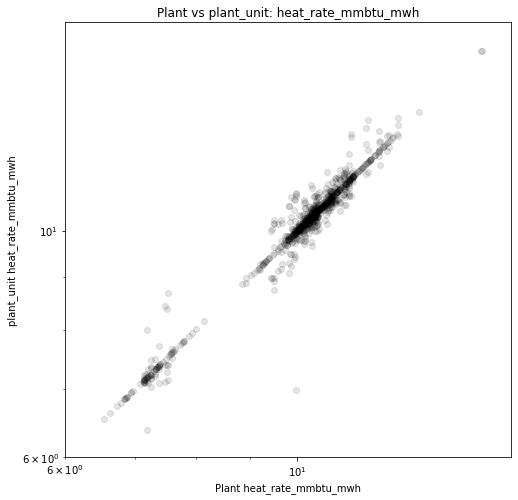

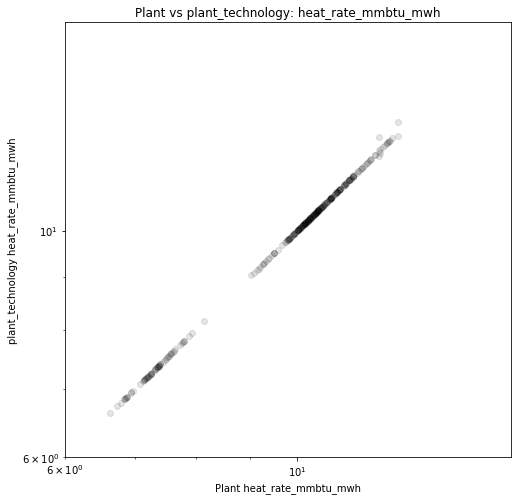

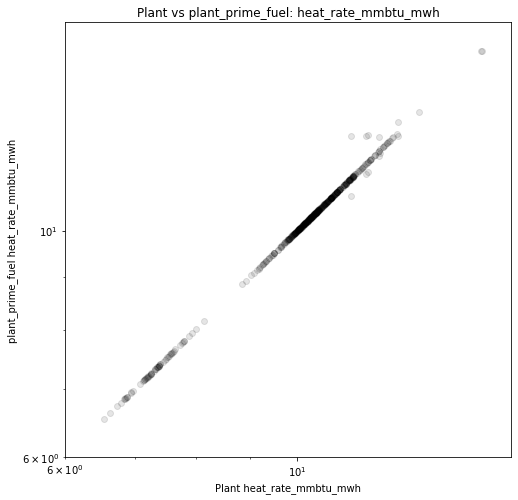

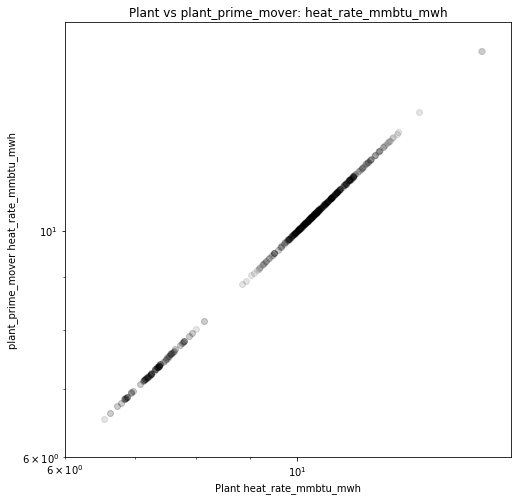

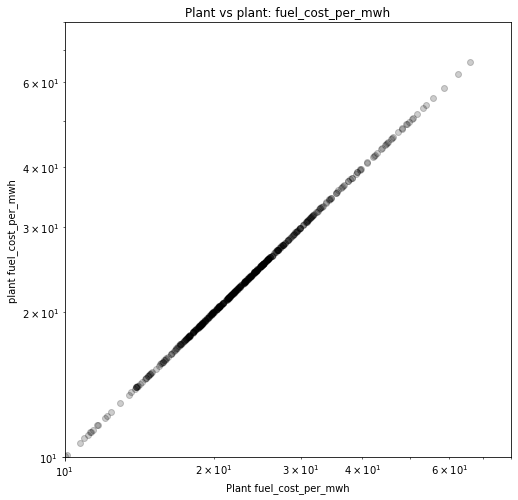

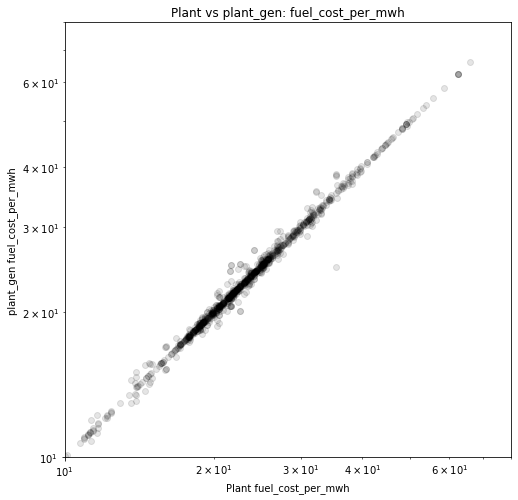

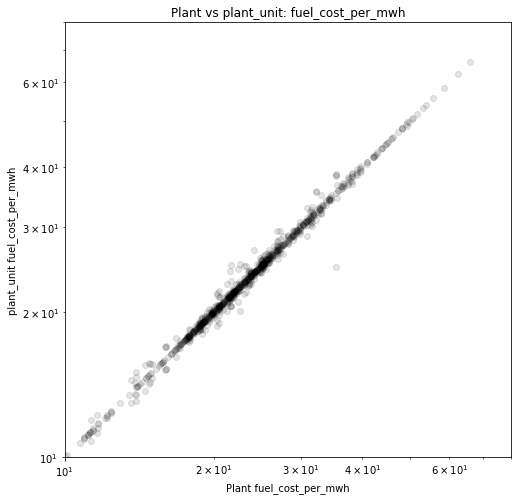

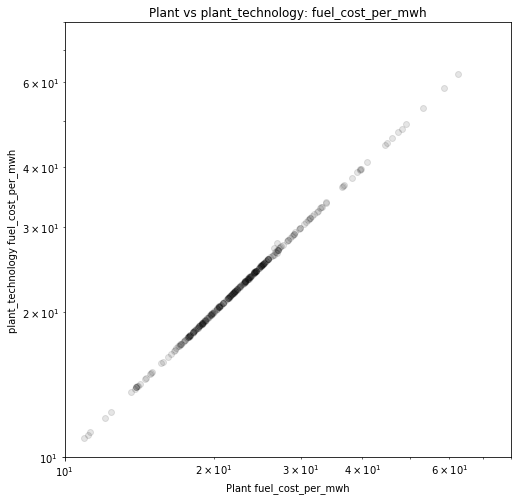

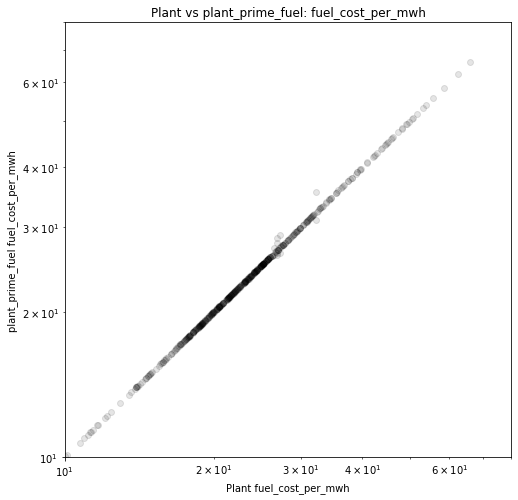

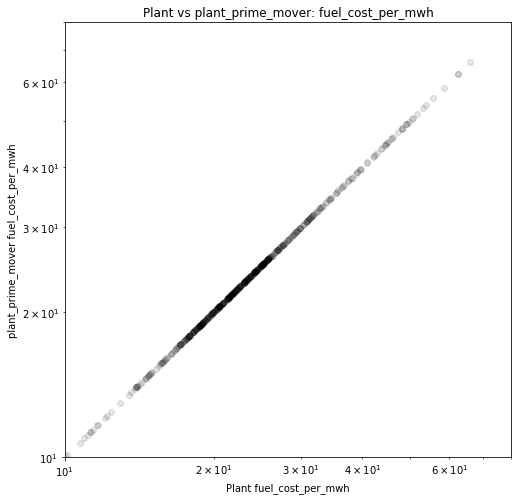

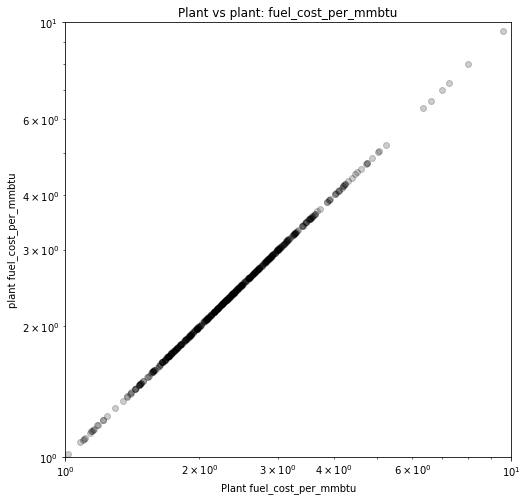

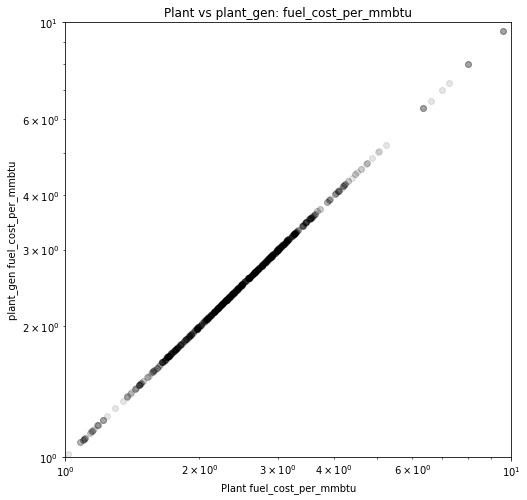

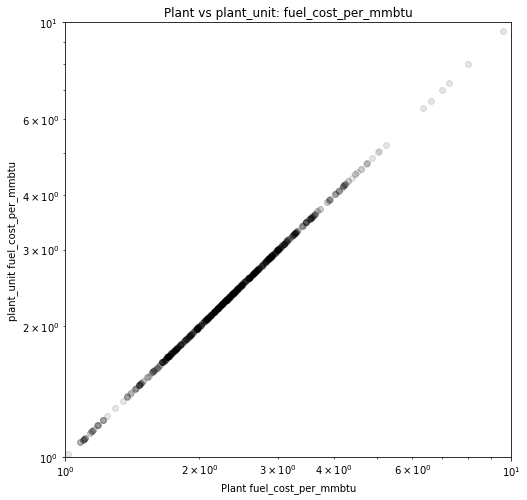

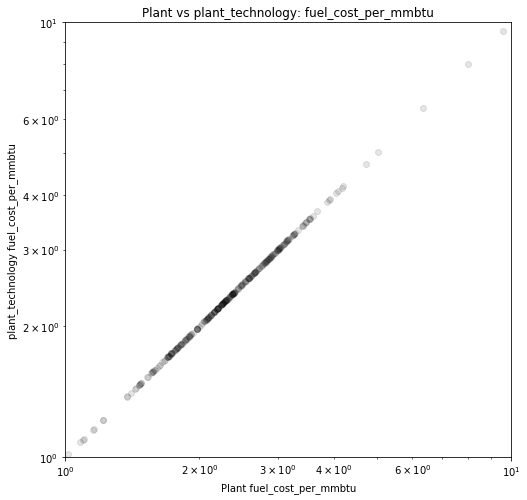

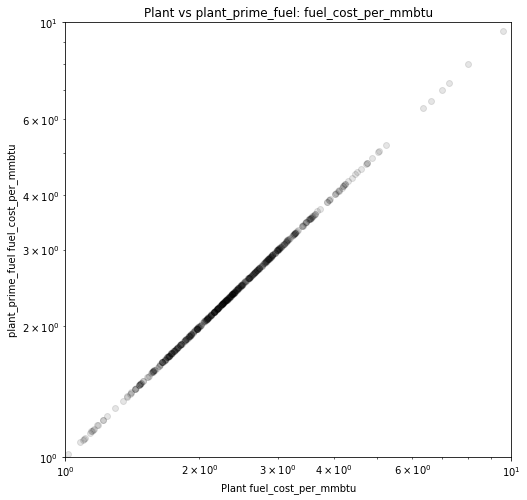

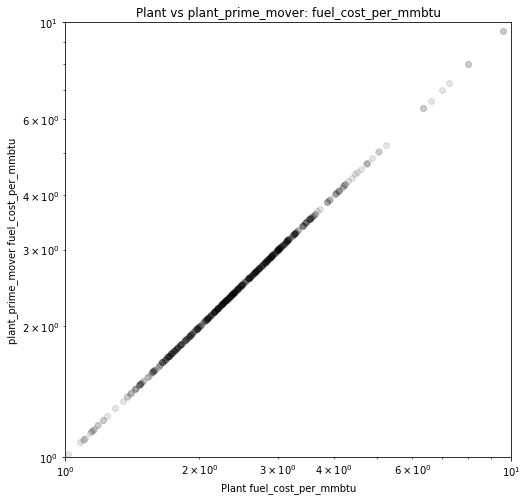

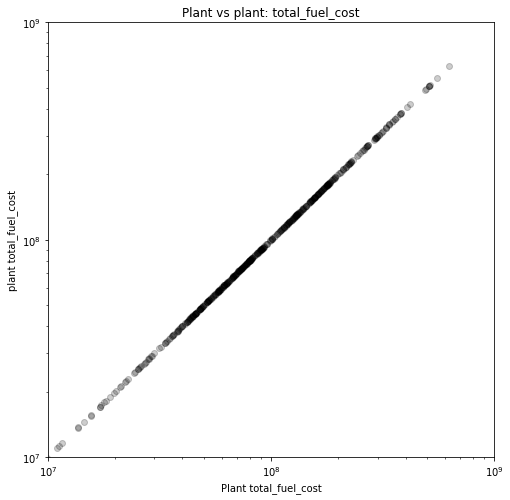

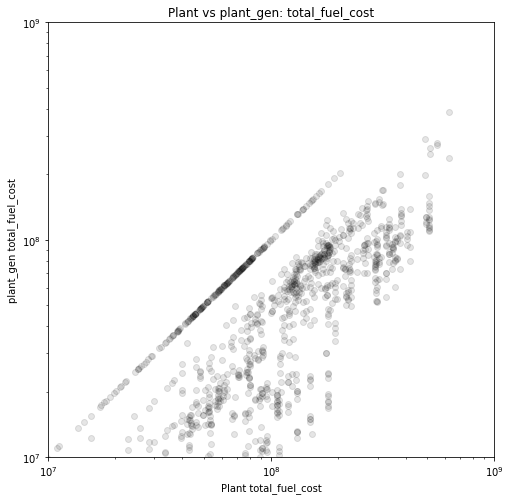

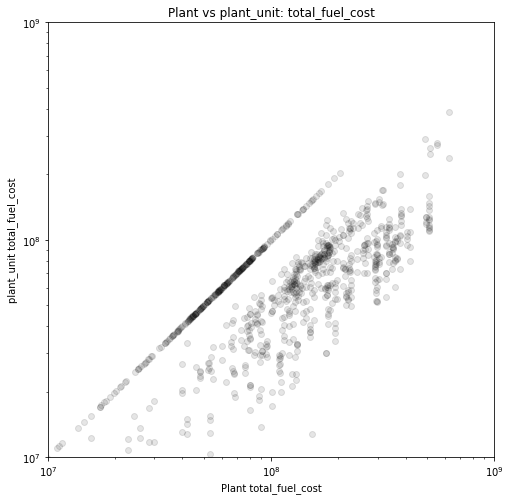

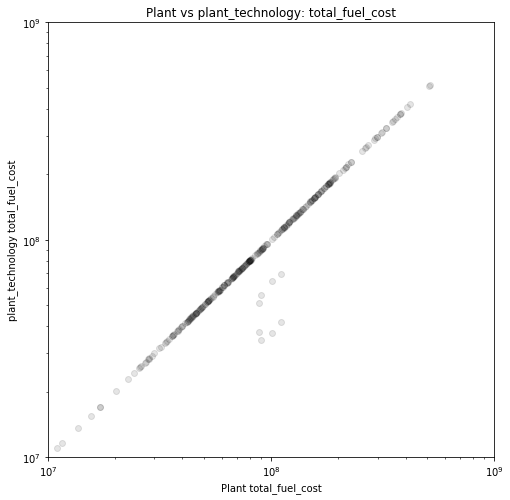

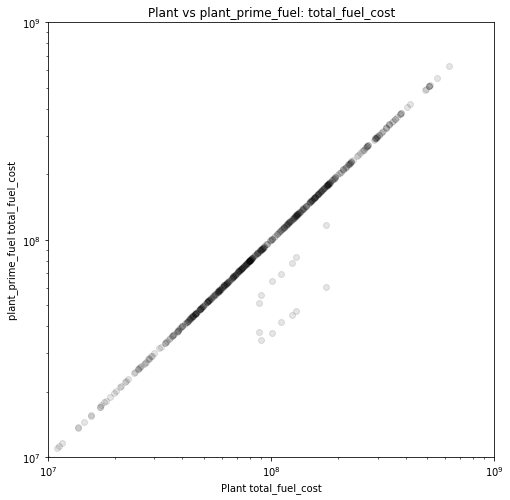

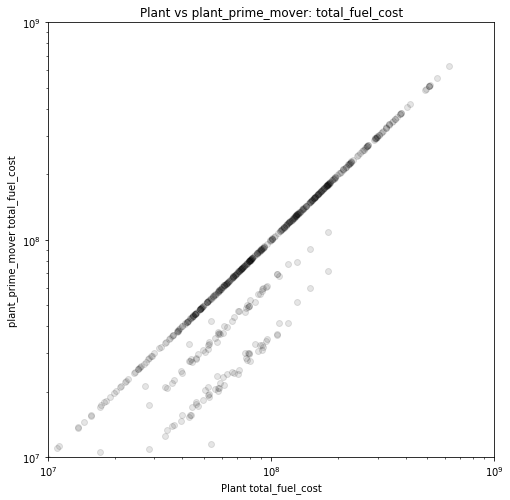

In [13]:
fields_to_plot = [
    # Simple Quantities
    'capacity_mw',
    #'opex_fuel',
    #'total_mmbtu',
    'net_generation_mwh',
    # Derived values
    #'capacity_factor',
    'heat_rate_mmbtu_mwh',
    'fuel_cost_per_mwh',
    'fuel_cost_per_mmbtu',
    'total_fuel_cost'
]

xy_limits = {
    # Simple Quantities
    'capacity_mw': (1e0, 1e4),
    'net_generation_mwh': (1e3,1e8),
    # Derived values
    'capacity_factor': (0,1.0),
    'heat_rate_mmbtu_mwh': (6,16),
    'fuel_cost_per_mwh': (10,80),
    'fuel_cost_per_mmbtu': (1e0,1e1),
    'total_fuel_cost': (1e7,1e9)
}

for field in fields_to_plot:
    plot_plant_vs_agg(compiled_plant_parts,field, xy_limits, scale="log")
#plot_eia_v_ferc1(pudl_dude, fields_to_plot, xy_limits)

## Playing with the compiled outputs 

In [14]:
# various tables to poke at for debuging
generat923 = self.grab_the_table('generation_eia923')
gens860 = self.grab_the_table('generators_eia860')
bga860 = self.grab_the_table('boiler_generator_assn_eia860')
own860 = self.grab_the_table('ownership_eia860')
frc923 = self.grab_the_table('fuel_receipts_costs_eia923')
plant = compiled_plant_parts['plant']
plant_gen = compiled_plant_parts['plant_gen']
plant_unit = compiled_plant_parts['plant_unit']
plant_fuel = compiled_plant_parts['plant_prime_fuel']
plant_tech = compiled_plant_parts['plant_technology']
plant_pm = compiled_plant_parts['plant_prime_mover']

   grabbing fuel_receipts_costs_eia923 from the sqlite db


In [15]:
count_df = pd.DataFrame(index=list(compiled_plant_parts['plant'].columns))
for k,cpp_df in compiled_plant_parts.items():
    count_df = count_df.merge(
        pd.DataFrame(cpp_df.count(), columns=[k]),
        right_index=True, left_index=True)

In [16]:
count_df

,plant,plant_gen,plant_unit,plant_technology,plant_prime_fuel,plant_prime_mover
plant_id_eia,9308,18627,3156,6116,9656,10606
report_date,9308,18627,3156,6116,9656,10606
utility_id_eia,9308,18627,3156,6116,9656,10606
fuel_cost_per_mmbtu,507,1023,868,296,514,572
heat_rate_mmbtu_mwh,507,1023,868,296,514,572
fuel_cost_per_mwh,507,1023,868,296,514,572
total_fuel_cost,9308,18627,3156,6116,9656,10606
net_generation_mwh,9308,18627,3156,6116,9656,10606
capacity_mw,9308,18627,3156,6116,9656,10606


In [17]:
# if you want to look at an individaul plant
plant_unit[plant_unit['plant_id_eia'] ==6179]

,plant_id_eia,unit_id_pudl,report_date,utility_id_eia,fuel_cost_per_mmbtu,heat_rate_mmbtu_mwh,fuel_cost_per_mwh,capacity_mw,net_generation_mwh,total_fuel_cost
1244,6179,1.0,2011-01-01,11269.0,2.399468,10.378843,24.903699,615.0,201258.0,9.615458e+07
1245,6179,1.0,2012-01-01,11269.0,2.226895,10.682607,23.789046,615.0,189022.0,7.950982e+07
1246,6179,1.0,2013-01-01,11269.0,2.172597,10.536326,22.891191,615.0,289836.0,8.128273e+07
1247,6179,1.0,2014-01-01,11269.0,NaN,NaN,NaN,615.0,337424.0,0.000000e+00
1248,6179,1.0,2015-01-01,11269.0,1.971776,10.719793,21.137030,615.0,213928.0,7.452688e+07
1249,6179,1.0,2016-01-01,11269.0,1.707508,10.699526,18.269528,615.0,267983.0,5.770087e+07
1250,6179,1.0,2017-01-01,11269.0,1.809432,10.560700,19.108869,615.0,346164.0,8.105967e+07
1251,6179,2.0,2011-01-01,11269.0,2.399468,10.330782,24.788378,615.0,348278.0,1.016744e+08
1252,6179,2.0,2012-01-01,11269.0,2.226895,10.670140,23.761282,615.0,219151.0,6.491722e+07
1253,6179,2.0,2013-01-01,11269.0,2.172597,10.473734,22.755202,615.0,264157.0,8.912653e+07


In [18]:
# selecting on two criteria (plant_id_eia and report_date)
plant_unit[(plant_unit['plant_id_eia'] == 260)]

,plant_id_eia,unit_id_pudl,report_date,utility_id_eia,fuel_cost_per_mmbtu,heat_rate_mmbtu_mwh,fuel_cost_per_mwh,capacity_mw,net_generation_mwh,total_fuel_cost


In [19]:
# you can see where fields are empty
plant_unit[plant_unit['capacity_mw'].isnull()]

,plant_id_eia,unit_id_pudl,report_date,utility_id_eia,fuel_cost_per_mmbtu,heat_rate_mmbtu_mwh,fuel_cost_per_mwh,capacity_mw,net_generation_mwh,total_fuel_cost


In [20]:
# you can see where fields are not empty
plant_unit[plant_unit['capacity_mw'].notnull()]

,plant_id_eia,unit_id_pudl,report_date,utility_id_eia,fuel_cost_per_mmbtu,heat_rate_mmbtu_mwh,fuel_cost_per_mwh,capacity_mw,net_generation_mwh,total_fuel_cost
0,10,1.0,2011-01-01,195.0,3.729278,10.136134,37.800465,299.2,129784.0,5.292409e+07
1,10,1.0,2012-01-01,195.0,3.610332,9.958157,35.952248,299.2,101080.0,3.843252e+07
2,10,1.0,2013-01-01,195.0,NaN,NaN,NaN,299.2,74882.0,0.000000e+00
3,10,1.0,2014-01-01,195.0,NaN,NaN,NaN,299.2,126122.0,0.000000e+00
4,10,1.0,2015-01-01,195.0,3.586874,10.265806,36.822148,299.2,70806.0,4.130473e+07
...,...,...,...,...,...,...,...,...,...,...
3151,59338,2.0,2014-01-01,56964.0,NaN,NaN,NaN,271.0,12294.0,0.000000e+00
3152,59784,1.0,2014-01-01,24211.0,NaN,NaN,NaN,619.0,0.0,0.000000e+00
3153,59784,1.0,2015-01-01,24211.0,3.105964,7.533991,23.400305,619.0,180577.0,5.079347e+07
3154,59784,1.0,2016-01-01,24211.0,2.926762,7.485960,21.909623,619.0,283827.0,5.229610e+07
